## Removing outliers from the dataset
The purpose of this notebook is to analyze the generated dataset for outliers. Outliers can have a negative impact on the training and performance of ASR model, so it's important to consider how to deal with them effectively.

This notebook introduces:
- Loading and visualizing the generated dataset
- Checking that spectrogram widths come from a normal distribution - this condition determines how outliers can be found
- Visualization of dataset using histogram - checking the distribution of samples
- Outlier detection using the Interquartile Range Method (IQR)
- Visualization of outliers using boxplot
- Visualization of dataset with outliers using histogram
- Removing outliers based on lower bound and upper bound values obtained from IQR method
- Visualization of dataset without outliers using histogram

Removing short or long spectrograms can help ensure data quality and training efficiency.

##### Consequences of outliers
For neural network training, the input data must be the same size - in the case of spectrograms, their height and width must be the same for each sample. The height of the spectrograms is fixed, as it is determined by the number of mel filters in filterbank. The width, on the other hand, is variable and it is determined by the length of the audio signal, so it must be standardized for each learning sample.

Before feeding the data into the input of the neural network, it is necessary to determine the minimum and maximum width of the spectrograms, so that they contain representative information. Spectrograms that are shorter than the maximum width can be padded, which can significantly increase the size of the input images. As a result, this leads to increased training time and inference - for this reason, spectrograms cannot be too long.
It is therefore necessary to select appropriate spectrogram widths so as to retain as much useful information as possible while keeping the image dimensions relatively small. This was done by removing outliers, which will allow the selection of appropriate samples to train the neural network.

In [1]:
import os
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from PIL import Image

sns.set(style="whitegrid")

In [2]:
# Load dataset samples from .feather file
DATA_PATH = '<PATH-TO-DATASET>'
LABELS_PATH = '<PATH-TO-LABELS>'
DATASET_NAME = '<DATASET-NAME.feather>'

datasetSamples = pd.read_feather(os.path.join(LABELS_PATH, DATASET_NAME))

# Print out some of the data for preview
datasetSamples.head(10)

,Spectrogram,Token
0,103-1240-0000.png,"[5, 10, 3, 18, 22, 7, 20, 1, 17, 16, 7, 1, 15,..."
1,103-1240-0001.png,"[22, 10, 3, 22, 1, 10, 3, 6, 1, 11, 22, 21, 1,..."
2,103-1240-0002.png,"[8, 17, 20, 1, 16, 17, 22, 1, 7, 24, 7, 16, 1,..."
3,103-1240-0003.png,"[3, 16, 6, 1, 22, 10, 3, 22, 1, 11, 8, 1, 21, ..."
4,103-1240-0004.png,"[4, 23, 22, 1, 15, 11, 21, 21, 23, 21, 1, 20, ..."
5,103-1240-0005.png,"[10, 7, 14, 18, 7, 6, 1, 20, 23, 16, 1, 22, 10..."
6,103-1240-0006.png,"[3, 21, 1, 3, 24, 17, 16, 14, 7, 3, 1, 10, 17,..."
7,103-1240-0007.png,"[3, 16, 27, 4, 17, 6, 27, 1, 25, 10, 17, 1, 25..."
8,103-1240-0008.png,"[22, 10, 7, 1, 17, 20, 5, 10, 3, 20, 6, 1, 17,..."
9,103-1240-0009.png,"[15, 11, 21, 21, 23, 21, 1, 20, 3, 5, 10, 7, 1..."


In [3]:
# Extract spectrogram names
spectrograms = datasetSamples['Spectrogram']

print("Dataset size: {}".format(len(spectrograms)))

# Print out some of the spectrogram names
spectrograms.head(5)

Dataset size: 28539


0    103-1240-0000.png
1    103-1240-0001.png
2    103-1240-0002.png
3    103-1240-0003.png
4    103-1240-0004.png
Name: Spectrogram, dtype: object

In [4]:
# Get width of each spectrogram
spectrograms_dict = dict()
spectrograms_width = list()

for spec_name in spectrograms:
    spec = Image.open(os.path.join(DATA_PATH, spec_name))
    width, height = spec.size
    
    if spec_name not in spectrograms_dict:
        spectrograms_dict[spec_name] = width

for value in spectrograms_dict.values():
    spectrograms_width.append(value)

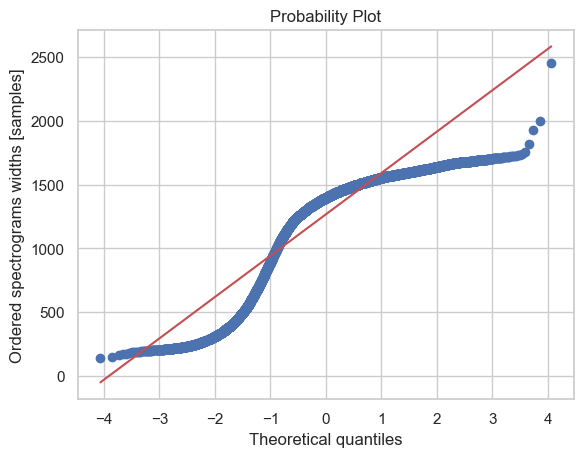

<Figure size 800x400 with 0 Axes>

In [5]:
# OUTLIERS DETECTION

# Check if the data comes from a Normal Distribution using QQ Plot (Quantile-Quantile)
fig, ax = plt.subplots()

qq_plot = stats.probplot(spectrograms_width, dist='norm', plot=plt)

plt.figure(figsize=(8, 4))

ax.set_xlabel("Theoretical quantiles")
ax.set_ylabel("Ordered spectrograms widths [samples]")
ax.set_title("Probability Plot")

plt.show()

The points deviate significantly from the straight diagonal line. This is an indication that the set of spectrograms width is not normally distributed.

In [6]:
# Visual representation - histogram
def prepare_histogram(widths: list, mark_outliers: bool = False, sns_plot: bool = False) -> (list, list):
    
    # Prepare histogram parameters
    min_val = np.min(widths)
    max_val = np.max(widths)

    observations_num = len(widths)
    observations_range = max_val - min_val

    intervals = int(np.ceil(np.sqrt(observations_num)))
    intervals_width = int(np.ceil(observations_range / intervals))

    hist_bins = list()

    for i in range(intervals):
        hist_bins.append(min_val + intervals_width * i)

    hist, edges = np.histogram(widths, hist_bins)

    plt.figure(figsize=(8, 4))
    
    if sns_plot:
        sns.histplot(data=widths, bins=hist_bins, kde=True)
        plt.title('Seaborn histogram - spectrograms widths')

    else:
        plt.bar(hist_bins[:-1], hist, width=intervals_width, align="edge", ec="k")
        plt.title('NumPy barplot - spectrograms widths histogram')

    
    if mark_outliers:
        plt.axvspan(xmin = lower_bound, xmax= np.min(widths), alpha=0.2, color='red')
        plt.axvspan(xmin = upper_bound, xmax= np.max(widths), alpha=0.2, color='red')
    
    plt.xlabel('Spectrograms width [samples]')
    plt.ylabel('Number of occurrences')
    

    plt.show()
    
    return hist, edges

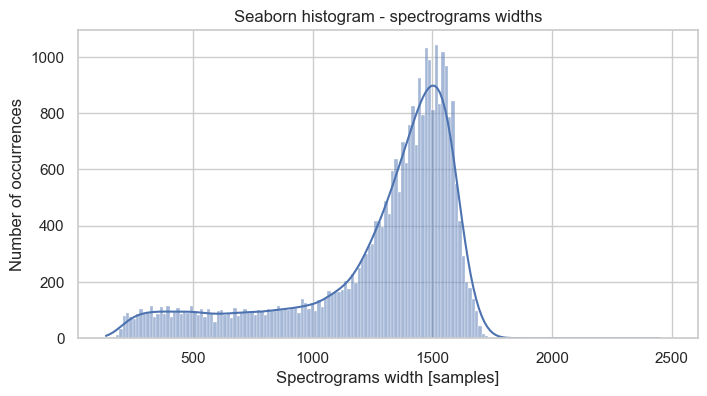

In [7]:
# Visualize spectrogram widths and determine its distribution
_, _ = prepare_histogram(spectrograms_width, mark_outliers=False, sns_plot=True)

Based on the above histogram, it was concluded that the widths of the spectrograms have the characteristics of a unimodal distribution - the IQR method was chosen to remove outliers.

In [8]:
# Outlier detection using the Interquartile Range Method (IQR)

# Sort data from low to high
sort_spec_width = sorted(spectrograms_width)

# Identify the first quartile (Q1), the median (Q2) and the third quartile (Q3)
Q1, Q2, Q3 = np.quantile(sort_spec_width, .25), np.quantile(sort_spec_width, .50), np.quantile(sort_spec_width, .75)

# Calculate IQR
IQR = Q3 - Q1

# Calculate upper and lower bounds
lower_bound = np.ceil(Q1 - 1.5 * IQR)
upper_bound = np.floor(Q3 + 1.5 * IQR)

print('--Parameters--',
      'Minimum value: {}'.format(np.min(sort_spec_width)),
      'Maximum value: {}'.format(np.max(sort_spec_width)),
      'Lower bound: {}'.format(lower_bound),
      'Upper bound: {}'.format(upper_bound), sep=os.linesep)

--Parameters--
Minimum value: 138
Maximum value: 2450
Lower bound: 626.0
Upper bound: 2045.0


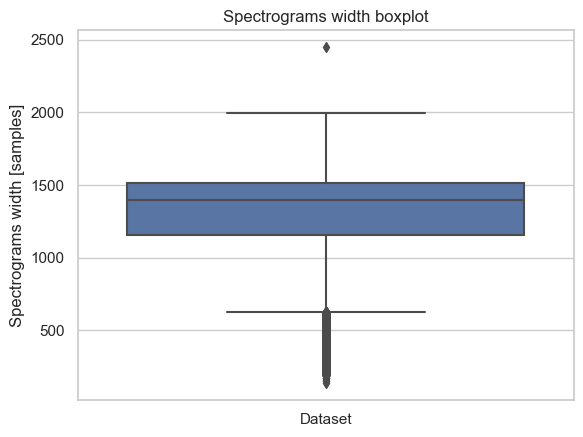

<Figure size 800x400 with 0 Axes>

In [9]:
# Prepare boxplot
fig, ax = plt.subplots()

boxplot = sns.boxplot(sort_spec_width, orient='vertical', whis=1.5, ax=ax)

plt.figure(figsize=(8, 4))

boxplot.set(ylabel='Spectrograms width [samples]', title="Spectrograms width boxplot", xticks=[0], xticklabels=['Dataset'])

plt.show()

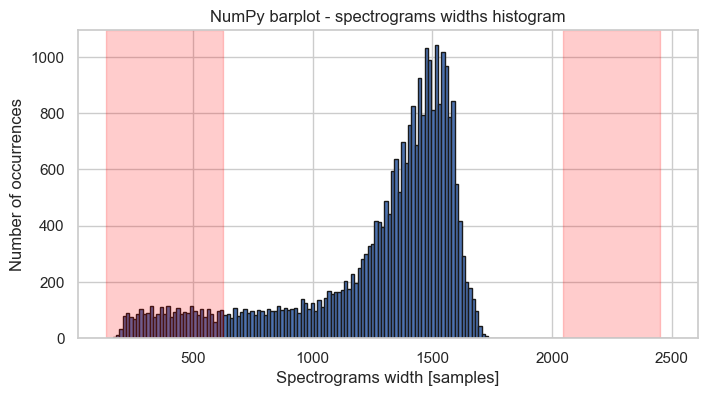

In [10]:
# Prepare histogram with outliers
_, _ = prepare_histogram(spectrograms_width, mark_outliers=True, sns_plot=False)

In [11]:
# Detect outliers from dataset
IQR_outliers = list()

for name, width in spectrograms_dict.items():
    if width < lower_bound or width > upper_bound:
        IQR_outliers.append(name)

print('Total number of outliers are: {}'.format(len(IQR_outliers)))

Total number of outliers are: 2770


In [12]:
# Remove outliers from dataset
cleaned_spectrograms_dict = dict()
cleaned_spectrograms_width = list()

cleaned_spectrograms_dict = {name: width for name, width in spectrograms_dict.items() if name not in IQR_outliers}

for value in cleaned_spectrograms_dict.values():
    cleaned_spectrograms_width.append(value)

print('Total number of samples in dataset: {}'.format(len(spectrograms_dict)),
      'Number of samples in dataset without outliers: {}'.format(len(cleaned_spectrograms_dict)), sep=os.linesep)

Total number of samples in dataset: 28539
Number of samples in dataset without outliers: 25769


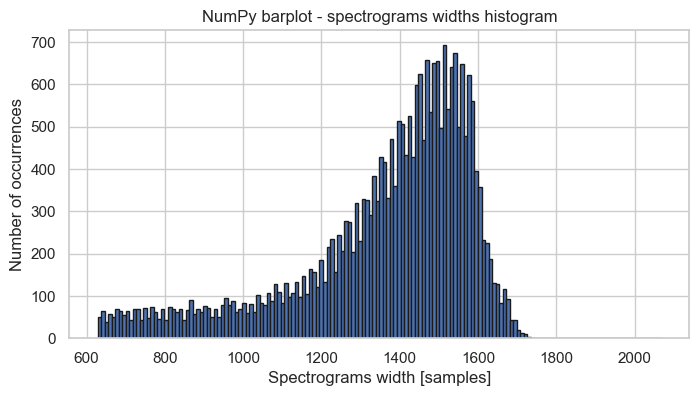

In [13]:
# Prepare histogram for dataset without outliers
hist, edges = prepare_histogram(cleaned_spectrograms_width)

In [14]:
# Analyse frequencies for each bin
hist_dict = dict()
hist_dict = {e: h for e, h in zip(edges, hist) if e not in hist_dict}

hist_df = pd.DataFrame([(edge, freq) for edge, freq in hist_dict.items()],
                                         columns=['Edges', 'Frequency'])

hist_df = hist_df[hist_df['Frequency'] >= 5]

print('Spectrograms width - HEAD', hist_df.head(5), '\n', sep=os.linesep)
print('Spectrograms width - TAIL', hist_df.tail(5), sep=os.linesep)

Spectrograms width - HEAD
   Edges  Frequency
0    628         50
1    637         65
2    646         38
3    655         56
4    664         51


Spectrograms width - TAIL
     Edges  Frequency
117   1681         42
118   1690         44
119   1699         19
120   1708         12
121   1717          9


In [15]:
# Outlier analysis
datasetOutliers = datasetSamples[datasetSamples['Spectrogram'].isin(IQR_outliers)]

# Print some of outliers
datasetOutliers.head(20)

,Spectrogram,Token
15,103-1240-0015.png,"[11, 8, 1, 10, 7, 2, 6, 1, 20, 23, 16, 1, 17, ..."
77,103-1241-0019.png,"[11, 1, 10, 3, 6, 1, 15, 3, 6, 7, 1, 23, 18, 1..."
83,103-1241-0025.png,"[11, 22, 2, 21, 1, 25, 17, 20, 21, 7, 1, 22, 1..."
101,103-1241-0043.png,"[3, 16, 6, 1, 3, 14, 22, 10, 17, 23, 9, 10, 1,..."
111,1034-121119-0009.png,"[25, 3, 21, 1, 3, 21, 5, 7, 16, 6, 11, 16, 9, ..."
112,1034-121119-0010.png,"[6, 7, 4, 20, 3, 27, 1, 25, 3, 21, 1, 17, 5, 5..."
114,1034-121119-0012.png,"[3, 16, 6, 1, 22, 10, 7, 1, 5, 17, 16, 24, 7, ..."
120,1034-121119-0018.png,"[3, 8, 22, 7, 20, 1, 25, 10, 11, 5, 10, 1, 22,..."
123,1034-121119-0021.png,"[8, 17, 20, 1, 11, 16, 1, 3, 1, 21, 17, 5, 11,..."
124,1034-121119-0022.png,"[3, 16, 6, 1, 10, 7, 20, 1, 9, 14, 3, 16, 5, 7..."


Once the outliers were detected, it was checked what files were designated for deletion from the database. Based on randomly selected spectrograms, it was shown that the too-short samples that were considered outliers last up to about 3 seconds and contain only a few single words. On the other hand, overly long samples last up to about 15 seconds and some of them have fragments of silence at the end. This analysis is the basis for their rejection.

In [16]:
print('---NEURAL NETWORK - DATASET PARAMETERS---',
      'Specified minimum sequence length: {}'.format(int(lower_bound)),
      'Specified maximum sequence length: {}'.format(hist_df["Edges"].iloc[-1]), sep=os.linesep)

---NEURAL NETWORK - DATASET PARAMETERS---
Specified minimum sequence length: 626
Specified maximum sequence length: 1717
